#### Import required modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc,Rectangle
import matplotlib.animation as animation
import PIL.Image as PILImage
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont 
from IPython.display import Image

#### Read csv and drop all NaNs existing


In [2]:
df = pd.read_csv('data.csv')
df.dropna(axis=0,how='all',inplace=True)
df.dropna(axis=1,how='all',inplace=True)

#### Column types

In [3]:
df.dtypes

id           int64
half         int64
point_x    float64
point_y    float64
time        object
match        int64
tag          int64
dtype: object

In [4]:
# Cast time column to datetime
df.time = pd.to_datetime(df.time)
df.dtypes

id                  int64
half                int64
point_x           float64
point_y           float64
time       datetime64[ns]
match               int64
tag                 int64
dtype: object

In [5]:
df.head()

,id,half,point_x,point_y,time,match,tag
0,1,1,101.1491,278.9296,2018-03-11 10:14:24,4,6
1,2,1,168.8316,343.1585,2018-03-11 10:14:25,4,12
2,3,1,43.2572,256.8387,2018-03-11 10:14:25,4,5
3,4,1,90.5040,144.5932,2018-03-11 10:14:25,4,3
4,5,1,101.9848,401.1742,2018-03-11 10:14:25,4,1


In [6]:
match = df.match.unique()[0]
match

4

#### Delete unnecessary columns

In [7]:
# Since we won't need id and match
del df['id'], df['match']
df.head()

,half,point_x,point_y,time,tag
0,1,101.1491,278.9296,2018-03-11 10:14:24,6
1,1,168.8316,343.1585,2018-03-11 10:14:25,12
2,1,43.2572,256.8387,2018-03-11 10:14:25,5
3,1,90.5040,144.5932,2018-03-11 10:14:25,3
4,1,101.9848,401.1742,2018-03-11 10:14:25,1


In [8]:
# There might be multiple x&y locations for a tag at a second.
df.groupby(['half','tag','time']).count().head(10)

point_x  point_y
half tag time                                 
1    1   2018-03-11 10:14:25        2        2
         2018-03-11 10:14:26        1        1
         2018-03-11 10:14:27        1        1
         2018-03-11 10:14:28        2        2
         2018-03-11 10:14:30        2        2
         2018-03-11 10:14:31        3        3
         2018-03-11 10:14:32        2        2
         2018-03-11 10:14:33        3        3
         2018-03-11 10:14:34        2        2
         2018-03-11 10:14:35        2        2

#### Fix duplicate values 

In [9]:
df = df.groupby(['half', 'tag', 'time'])['point_x', 'point_y'].mean().reset_index()
df.groupby(['half','tag','time']).count().head(10)

point_x  point_y
half tag time                                 
1    1   2018-03-11 10:14:25        1        1
         2018-03-11 10:14:26        1        1
         2018-03-11 10:14:27        1        1
         2018-03-11 10:14:28        1        1
         2018-03-11 10:14:30        1        1
         2018-03-11 10:14:31        1        1
         2018-03-11 10:14:32        1        1
         2018-03-11 10:14:33        1        1
         2018-03-11 10:14:34        1        1
         2018-03-11 10:14:35        1        1

### Interpolation Function 

In [10]:
# Interpolates original data and returns new data frame
def get_interpolated_data(data_f,interval):
    df_temp = pd.DataFrame(columns=data_f.columns)
    for half in [1,2]:
        data = data_f[data_f.half == half].copy()
        tags = data.tag.unique()
        for t in tags:
            tag_data = data[data.tag == t].copy()
            d = tag_data.set_index('time').resample(interval).interpolate().reset_index()
            d = d.fillna({'half': half, 'tag': t})
            df_temp = df_temp.append(d)
    df_temp.reset_index(drop=True, inplace=True)
    df_temp.half = df_temp.half.astype('int')
    df_temp.tag =  df_temp.tag.astype('int')
    return df_temp

In [11]:
interval = '125ms' # This could be 'S'. For further information check resources section
df_interpolated = get_interpolated_data(df, interval)
df_interpolated.head(10)

,half,point_x,point_y,tag,time
0,1,101.984800,401.174200,1,2018-03-11 10:14:25.000
1,1,107.928888,395.230113,1,2018-03-11 10:14:25.125
2,1,113.872975,389.286025,1,2018-03-11 10:14:25.250
3,1,119.817063,383.341937,1,2018-03-11 10:14:25.375
4,1,125.761150,377.397850,1,2018-03-11 10:14:25.500
5,1,131.705238,371.453763,1,2018-03-11 10:14:25.625
6,1,137.649325,365.509675,1,2018-03-11 10:14:25.750
7,1,143.593412,359.565587,1,2018-03-11 10:14:25.875
8,1,149.537500,353.621500,1,2018-03-11 10:14:26.000
9,1,150.868025,350.221400,1,2018-03-11 10:14:26.125


#### Calculate distance covered by each tag at each half

In [12]:
df_dist = df_interpolated.copy()
dx = (df_dist['point_x'] - df_dist.groupby(['half', 'tag'])['point_x'].shift()).fillna(0)
dy = (df_dist['point_y'] - df_dist.groupby(['half', 'tag'])['point_y'].shift()).fillna(0)
df_dist['diff'] = np.sqrt(dx ** 2 + dy ** 2)
d_frame = df_dist.groupby(['half', 'tag'], as_index=False)['diff'].sum()
d_frame.columns.values[2] = 'distance'
d_frame.distance = (np.round(d_frame.distance / 10, decimals=0)).astype(int)
d_frame

,half,tag,distance
0,1,1,2681
1,1,2,2179
2,1,3,2940
3,1,4,2611
4,1,5,2241
5,1,6,2664
6,1,7,3478
7,1,8,2085
8,1,9,2917
9,1,11,2461


In [13]:
# Calculate total distance covered by each tag
d_tag = d_frame.groupby(['tag'], as_index=False)['distance'].sum()\
                                                    .sort_values('distance', ascending = False)\
                                                    .reset_index(drop=True)
d_tag        

,tag,distance
0,7,6410
1,3,6363
2,9,5814
3,6,5640
4,1,5553
5,12,5182
6,11,5122
7,4,5112
8,5,4811
9,2,4747


#### Get Tag and Team relation

In [14]:
tag_team_df = pd.read_csv('tag_team.csv')
tag_team_df.dropna(axis=0,how='any',inplace=True)
tag_team_df

,tag,team,player
0,12,8,Cumhur Sadık
1,8,8,Cevahir Avcı
2,7,8,Kerim Aslan
3,10,8,Selahattin Macar
4,9,8,Vedat Demirci
5,11,8,Ozan Balık
6,6,9,Vahit Uzun
7,5,9,Engin Teke
8,3,9,Kudret Yılmaz
9,4,9,Fevzi Badem


#### Calculate total distance covered by each team

In [15]:
dist_f_tag_team = pd.merge(d_tag, tag_team_df, how='inner',
                              on=['tag']).reset_index(drop=True)

dist_f_tag_team.groupby(['team'], as_index=False)['distance'].sum()\
                                                    .sort_values('distance', ascending = False)\
                                                    .reset_index(drop=True)

,team,distance
0,9,32226
1,8,26751


In [16]:
dist_f_tag_team

,tag,distance,team,player
0,7,6410,8,Kerim Aslan
1,3,6363,9,Kudret Yılmaz
2,9,5814,8,Vedat Demirci
3,6,5640,9,Vahit Uzun
4,1,5553,9,Nuh Koç
5,12,5182,8,Cumhur Sadık
6,11,5122,8,Ozan Balık
7,4,5112,9,Fevzi Badem
8,5,4811,9,Engin Teke
9,2,4747,9,Demir Solak


In [17]:
# Average distances for teams
dist_team_avg = dist_f_tag_team.groupby(['team'], as_index=False)['distance'].mean()\
                                                    .sort_values('distance', ascending = False)\
                                                    .reset_index(drop=True)
dist_team_avg        

,team,distance
0,9,5371.0
1,8,5350.2


#### Creating team distance ranks with a background image

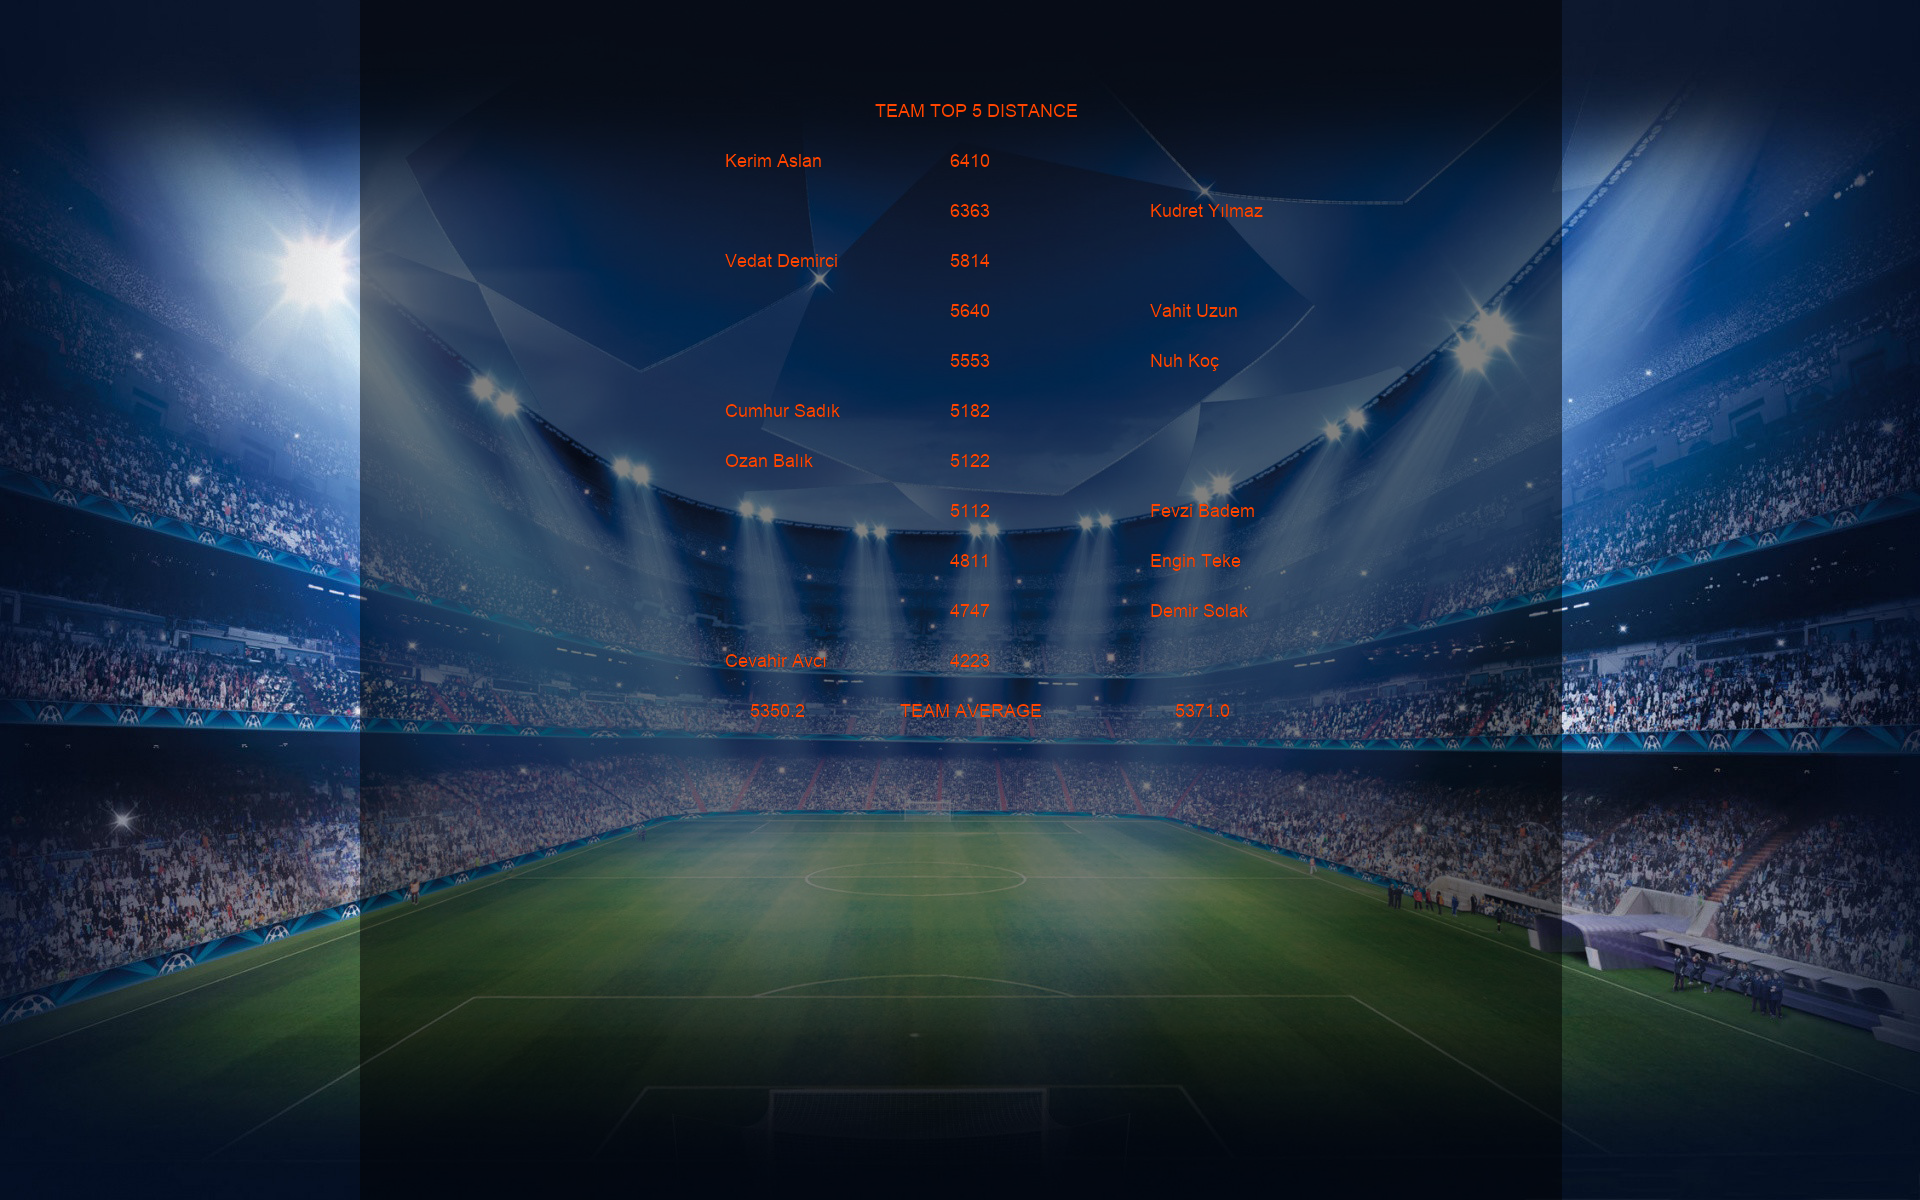

In [18]:
img = PILImage.open('/home/enes/Desktop/SoccerAnalysis/Soccer-Analysis-Python/soccer_bg.jpg')
img = img.convert("RGBA")

# Make a blank image for the rectangle, initialized to a completely
# transparent color.
tmp = PILImage.new('RGBA', img.size, (0,0,0,0))

# Create a drawing context for it.
draw = ImageDraw.Draw(tmp)

# Determine the bounding box of the largest possible semi-transparent
# square rectangle centered on the temporary image and draw it.
if img.size[0] > img.size[1]:
    size = img.size[1]
    llx, lly = (img.size[0] - img.size[1]) // 2, 0
else:
    size = img.size[0]
    llx, lly = 0, (img.size[1] - img.size[0]) // 2

# Add one to upper point because second point is just outside the drawn
# rectangle.
urx, ury = llx + size + 1, lly + size + 1
draw.rectangle(((llx, lly), (urx, ury)), fill=(0,0,0,127))
font_type = ImageFont.truetype('Arial.ttf',18)

draw.text(xy=(875,100), text='TEAM DISTANCE RANK', fill=(139,0,0), font=font_type)
draw.text(xy=(900,100+50*(len(dist_f_tag_team)+1)), text='TEAM AVERAGE', fill=(139,0,0), font=font_type)

for ind in range(len(dist_f_tag_team)):
    tag = dist_f_tag_team.loc[ind].tag
    distance = dist_f_tag_team.loc[ind].distance
    team = dist_f_tag_team.loc[ind].team
    name = dist_f_tag_team.loc[ind].player
    if team % 2 == 0:
        draw.text(xy=(725,100+50*(ind+1)), text=name, fill=(139,0,0), font=font_type)
        draw.text(xy=(950,100+50*(ind+1)), text=str(distance), fill=(139,0,0), font=font_type)
    else:
        draw.text(xy=(1150,100+50*(ind+1)), text=name, fill=(139,0,0), font=font_type)
        draw.text(xy=(950,100+50*(ind+1)), text=str(distance), fill=(139,0,0), font=font_type)
        
for t in range(2):
    team = dist_team_avg.loc[t].team
    dist_avg = dist_team_avg.loc[t].distance
    if team % 2 == 0:
        draw.text(xy=(750,100+50*(len(dist_f_tag_team)+1)), text=str(dist_avg), fill=(139,0,0), font=font_type)
    else:
        draw.text(xy=(1175,100+50*(len(dist_f_tag_team)+1)), text=str(dist_avg), fill=(139,0,0), font=font_type)
        
# Alpha composite the two images together.
img = PILImage.alpha_composite(img, tmp)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
#img.save('soc_bg_with_dist.png')
#img.show()
Image(filename='soc_bg_with_dist.png') 


#### Drawing a pitchmap

In [19]:
PITCH_WIDTH = 90
PITCH_LENGTH = 130


def create_pitch(is_for_heatmap=False, is_for_animation=False):
    
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    
    if not is_for_heatmap:
        #Draw Pitch Pattern
        for i in range(10):      
            r = Rectangle(
                (i*13, 0), 13, 90,
                facecolor= "#6CB92F" if i%2 == 0 else "#36780A"
            )    
            ax.add_patch(r)
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    centreSpot = plt.Circle((65,45),0.8,color="black")
    leftPenSpot = plt.Circle((11,45),0.8,color="black")
    rightPenSpot = plt.Circle((119,45),0.8,color="black")
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    
    #Tidy Axes
    plt.axis('off')
    
    plt.ylim(0, 90)
    plt.xlim(0, 130)
    
    if is_for_animation:
        return fig, ax
    else:
        return plt

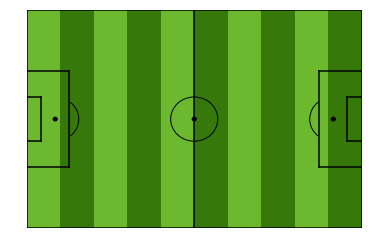

In [20]:
plt = create_pitch()
plt.show()

In [21]:
def create_heat_map():
    
    data = df_interpolated.copy()

    #calculate max and min values
    max_x=int(data.point_x.max()/10)
    min_x=int(data.point_x.min()/10)
    max_y=int(data.point_y.max()/10)
    min_y=int(data.point_y.min()/10)

    data.point_x = (data.point_x/10).round()
    data.point_y = (data.point_y/10).round()

    #normalize x and y values
    data.point_x = (((data.point_x-min_x)/(max_x-min_x))*PITCH_WIDTH).round()
    data.point_y = (((data.point_y-min_y)/(max_y-min_y))*PITCH_LENGTH).round()
    tags = data.tag.unique()        

    for tag in tags:
        data_tag = data[data.tag == tag].copy()
        data_tag.reset_index(inplace=True, drop=True)

        # Since teams switch sides at second half
        data_tag.loc[data_tag.half == 2,'point_x'] = (PITCH_WIDTH - data_tag.loc[data_tag.half == 2,'point_x']).values
        data_tag.loc[data_tag.half == 2,'point_y'] = (PITCH_WIDTH - data_tag.loc[data_tag.half == 2,'point_y']).values

        #Display Pitch
        plt = create_pitch(is_for_heatmap=True)
        plt.title('Match_%d_Tag_%d.svg' %(match,tag))
        sns.kdeplot(data_tag["point_y"], data_tag["point_x"], shade=True, n_levels=100,\
                    kernel='epa', cmap="Reds", bw=0)
        plt.show()

        # If you want to save the figure to your computer, uncomment the following line
        #plt.savefig(('Match_%d_Tag_%d.svg' %(match,tag)), format='svg', dpi=1200,  bbox_inches='tight',  pad_inches = 0)

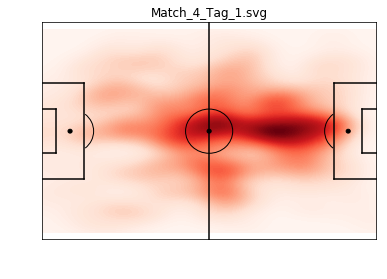

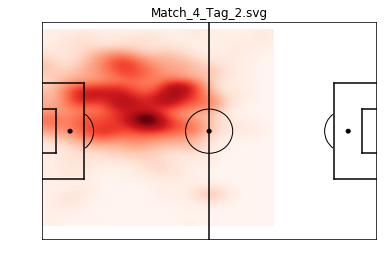

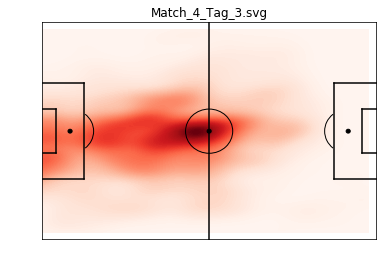

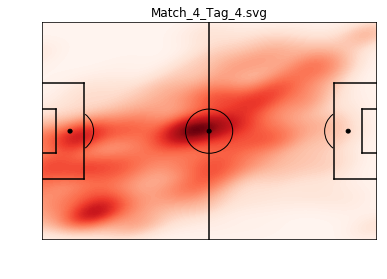

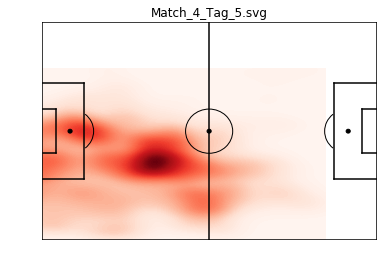

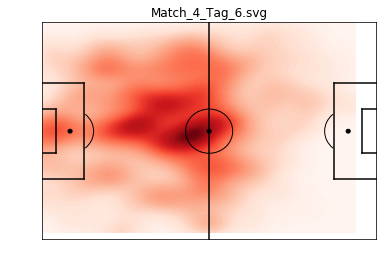

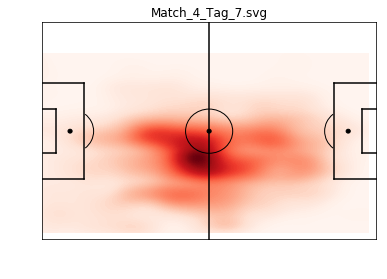

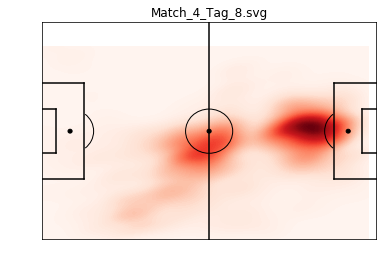

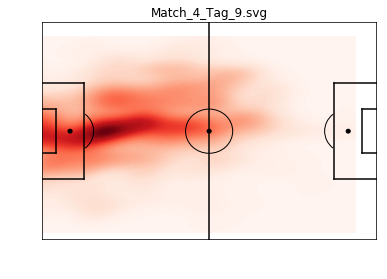

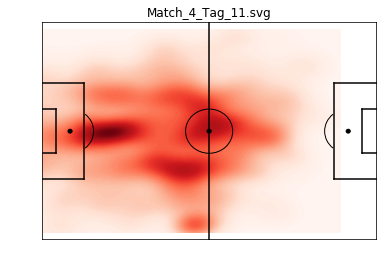

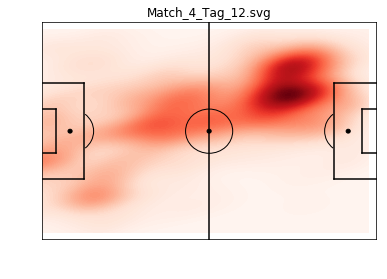

In [22]:
create_heat_map()

In [23]:
# Get and normalize data for animation
data = df_interpolated.copy()

#calculate max and min values
max_x=int(data.point_x.max()/10)
min_x=int(data.point_x.min()/10)
max_y=int(data.point_y.max()/10)
min_y=int(data.point_y.min()/10)

data.point_x = (data.point_x/10).round()
data.point_y = (data.point_y/10).round()

#normalize x and y values
data.point_x = (((data.point_x-min_x)/(max_x-min_x))*PITCH_WIDTH).round()
data.point_y = (((data.point_y-min_y)/(max_y-min_y))*PITCH_LENGTH).round()

In [24]:
# We will use only first half for demonstration purpose.
# We will make sure that we have location for each at each socond.

data = data[data.half == 1].sort_values(['time', 'tag'])\
                              .reset_index(drop=True)[8:128659]\
                              .reset_index(drop=True)
# We don't need half&time column        
del data['half'], data['time']

In [25]:
# Since pitch drawn is horizontal, we need to switch x&y locations
data.columns = ['point_y','point_x','tag']
data.head()

,point_y,point_x,tag
0,29.0,107.0,1
1,58.0,34.0,2
2,26.0,34.0,3
3,32.0,65.0,4
4,10.0,68.0,5


In [26]:
# Different color for each tag
tags = data.tag.unique()
palette = sns.color_palette(None, len(tags))
COLOR_COLUMN_NAMES=['tag','color']
color_frame = pd.DataFrame(columns=COLOR_COLUMN_NAMES)
color_frame.tag = tags
color_frame.color = palette

In [27]:
color_frame

,tag,color
0,1,"(0.12156862745098039, 0.4666666666666667, 0.70..."
1,2,"(1.0, 0.4980392156862745, 0.054901960784313725)"
2,3,"(0.17254901960784313, 0.6274509803921569, 0.17..."
3,4,"(0.8392156862745098, 0.15294117647058825, 0.15..."
4,5,"(0.5803921568627451, 0.403921568627451, 0.7411..."
5,6,"(0.5490196078431373, 0.33725490196078434, 0.29..."
6,8,"(0.8901960784313725, 0.4666666666666667, 0.760..."
7,9,"(0.4980392156862745, 0.4980392156862745, 0.498..."
8,11,"(0.7372549019607844, 0.7411764705882353, 0.133..."
9,12,"(0.09019607843137255, 0.7450980392156863, 0.81..."


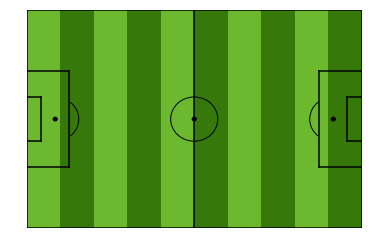

In [28]:
fig,ax = create_pitch(is_for_animation=True)
n=1
                   
def update_plot(i, data, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11):
    p1.set_data(np.array([data[data.tag == tags[0]]['point_x'][i:i+n].values, data[data.tag == tags[0]]['point_y'][i:i+n].values]))
    p2.set_data(np.array([data[data.tag == tags[1]]['point_x'][i:i+n].values, data[data.tag == tags[1]]['point_y'][i:i+n].values]))
    p3.set_data(np.array([data[data.tag == tags[2]]['point_x'][i:i+n].values, data[data.tag == tags[2]]['point_y'][i:i+n].values]))
    p4.set_data(np.array([data[data.tag == tags[3]]['point_x'][i:i+n].values, data[data.tag == tags[3]]['point_y'][i:i+n].values]))  
    p5.set_data(np.array([data[data.tag == tags[4]]['point_x'][i:i+n].values, data[data.tag == tags[4]]['point_y'][i:i+n].values]))  
    p6.set_data(np.array([data[data.tag == tags[5]]['point_x'][i:i+n].values, data[data.tag == tags[5]]['point_y'][i:i+n].values]))  
    p7.set_data(np.array([data[data.tag == tags[6]]['point_x'][i:i+n].values, data[data.tag == tags[6]]['point_y'][i:i+n].values]))  
    p8.set_data(np.array([data[data.tag == tags[7]]['point_x'][i:i+n].values, data[data.tag == tags[7]]['point_y'][i:i+n].values]))
    p9.set_data(np.array([data[data.tag == tags[8]]['point_x'][i:i+n].values, data[data.tag == tags[8]]['point_y'][i:i+n].values]))
    p10.set_data(np.array([data[data.tag == tags[9]]['point_x'][i:i+n].values, data[data.tag == tags[9]]['point_y'][i:i+n].values]))
    p11.set_data(np.array([data[data.tag == tags[10]]['point_x'][i:i+n].values, data[data.tag == tags[10]]['point_y'][i:i+n].values]))  
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11
                   
def main():
    p1, = ax.plot(data[data.tag == tags[0]]['point_x'][0:n], data[data.tag == tags[0]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[0]].reset_index(drop=True).loc[0].color)
    p2, = ax.plot(data[data.tag == tags[1]]['point_x'][0:n], data[data.tag == tags[1]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[1]].reset_index(drop=True).loc[0].color)
    p3, = ax.plot(data[data.tag == tags[2]]['point_x'][0:n], data[data.tag == tags[2]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[2]].reset_index(drop=True).loc[0].color)
    p4, = ax.plot(data[data.tag == tags[3]]['point_x'][0:n], data[data.tag == tags[3]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[3]].reset_index(drop=True).loc[0].color)
    p5, = ax.plot(data[data.tag == tags[4]]['point_x'][0:n], data[data.tag == tags[4]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[4]].reset_index(drop=True).loc[0].color)
    p6, = ax.plot(data[data.tag == tags[5]]['point_x'][0:n], data[data.tag == tags[5]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[5]].reset_index(drop=True).loc[0].color)
    p7, = ax.plot(data[data.tag == tags[6]]['point_x'][0:n], data[data.tag == tags[6]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[6]].reset_index(drop=True).loc[0].color)
    p8, = ax.plot(data[data.tag == tags[7]]['point_x'][0:n], data[data.tag == tags[7]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[7]].reset_index(drop=True).loc[0].color)                  
    p9, = ax.plot(data[data.tag == tags[8]]['point_x'][0:n], data[data.tag == tags[8]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[8]].reset_index(drop=True).loc[0].color)
    p10, = ax.plot(data[data.tag == tags[9]]['point_x'][0:n], data[data.tag == tags[9]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[9]].reset_index(drop=True).loc[0].color)
    p11, = ax.plot(data[data.tag == tags[10]]['point_x'][0:n], data[data.tag == tags[10]]['point_y'][0:n], 'o', c=color_frame[color_frame.tag == tags[10]].reset_index(drop=True).loc[0].color)
    
    # This will create animation for the first three minutes of the match
    # Note that animation file will be saved to the current directory.
    ani = animation.FuncAnimation(fig, update_plot, frames=range(1,3*60*8), fargs=(data,p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11))
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=-1)

    ani.save('ani.mp4', writer=writer)


#main()

# In case you have problem in using writer ***ffmpeg*** 

[Stack Over Flow- Related Answers](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available/14574894#14574894)

### Resources and References

[Pandas Resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)

[Pandas Interpolate](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html)

[Drawing a pitchmap](https://fcpython.com/visualisation/drawing-pitchmap-adding-lines-circles-matplotlib)

[Seaborn KDE Plot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

[Matplotlib Animation](https://matplotlib.org/api/animation_api.html)

[Pillow Usage from SO](https://stackoverflow.com/a/43620169/3982398)
